In [41]:
%matplotlib inline
import os
from pathlib import Path
import json

import pandas as pd
import numpy as np

import skimage


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import seaborn as sns
from tqdm import trange, tqdm, tqdm_notebook

from fastai.datasets import Config
import wget

import warnings
warnings.filterwarnings("ignore")

base_path = Config.data_path()

# Competiton files setup

In [3]:
data_path = base_path/'Open_Images_2019_Object_Detection'
competition_name = 'open-images-2019-object-detection'
train_images_path = data_path/'images'/'train'
validation_images_path = data_path/'images'/'validation'
data_path.mkdir(parents=True, exist_ok=True)
data_path

PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection')

In [20]:
!kaggle competitions files -c {competition_name}

name                   size  creationDate         
---------------------  ----  -------------------  
sample_submission.csv   8MB  2019-05-29 23:04:17  
test.zip               10GB  2019-05-29 23:02:56  


In [21]:
!kaggle competitions download --force -c {competition_name} -p {data_path}

  0%|                                               | 0.00/1.07M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 1.07M/1.07M [00:00<00:00, 118MB/s]
100%|█████████████████████████████████████▉| 9.67G/9.69G [03:53<00:00, 85.8MB/s]
100%|██████████████████████████████████████| 9.69G/9.69G [03:53<00:00, 44.6MB/s]


In [24]:
from zipfile import ZipFile

file_name = "sample_submission.csv.zip"
print(f"Unziping {file_name} ...")
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(data_path)

os.remove(data_path/file_name)
print("Done")

file_name = "test.zip"
print(f"Unziping {file_name} ...")
test_images_path = data_path/'images'/'test'
test_images_path.mkdir(exist_ok=True, parents=True)
with ZipFile(data_path/file_name, 'r') as zip_ref:
    zip_ref.extractall(test_images_path)

os.remove(data_path/file_name)
print("Done")

Unziping test.zip ...
Done


In [26]:
labels_path = data_path/'labels'
labels_path.mkdir(exist_ok=True)
train_labels_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-train-detection-human-imagelabels.csv'
train_labels_file = wget.download(train_labels_url, out=str(labels_path/'train.csv'))
validation_labels_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-validation-detection-human-imagelabels.csv'
validation_labels_file = wget.download(validation_labels_url, out=str(labels_path/'validation.csv'))

boxes_path = data_path/'boxes'
boxes_path.mkdir(exist_ok=True)
train_boxes_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-train-detection-bbox.csv'
train_boxes_file = wget.download(train_boxes_url, out=str(boxes_path/'train.csv'))
validation_boxes_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-validation-detection-bbox.csv'
validation_boxes_file = wget.download(validation_boxes_url, out=str(boxes_path/'validation.csv'))

classes_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-classes-description-500.csv'
classes_file = wget.download(classes_url, out=str(data_path/'classes.csv'))

class_hierarchy_url = 'https://storage.googleapis.com/openimages/challenge_2019/challenge-2019-label500-hierarchy.json'
class_hierarchy_file = wget.download(class_hierarchy_url, out=str(data_path/'class_hierarchy.json'))

In [27]:
from zipfile import ZipFile
import gdown

def download_resized_images(url: str) -> None:
    print("Downloading...")
    images_path = data_path/'images'
    images_path.mkdir(exist_ok=True, parents=True)
    destination_file = images_path/'temp.zip'
    gdown.download(url, str(destination_file), quiet=True)

    print("Unziping...")
    with ZipFile(destination_file, 'r') as zip_ref:
        zip_ref.extractall(images_path)

    os.remove(destination_file)
    print("Done")

In [28]:
# Download and unzip validation images
# All images resized to 512x512

validation_images_url = 'https://drive.google.com/uc?id=15FOZRVDEu8VZsIJ5nY5Y63A27kKtXoBu'
download_resized_images(validation_images_url)

Downloading...
Unziping...
Done


## Data exploration

In [4]:
data_path.ls()

[PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/class_hierarchy.json'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/images'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/classes.csv'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/boxes'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/labels'),
 PosixPath('/home/jupyter/.fastai/data/Open_Images_2019_Object_Detection/train')]

In [5]:
classes = pd.read_csv(data_path/'classes.csv', names=['Alias', 'Name'])
classes.head()

,Alias,Name
0,/m/061hd_,Infant bed
1,/m/06m11,Rose
2,/m/03120,Flag
3,/m/01kb5b,Flashlight
4,/m/0120dh,Sea turtle


In [6]:
code_to_class = dict()
class_to_code = dict()
with open(data_path/'classes.csv', 'r') as file:
    for line in file.readlines():
        code, class_name = line.strip().split(sep=',')
        code_to_class[code] = class_name
        class_to_code[class_name] = code

In [7]:
with open(data_path/'class_hierarchy.json', 'r') as json_file:
    class_hierarchy = json.load(json_file)

In [8]:
valid_labels = pd.read_csv(data_path/'labels'/'validation.csv')
valid_labels['Label as string'] = valid_labels.apply(lambda row: code_to_class[row.LabelName], axis=1)
valid_labels.head()

,ImageID,LabelName,Confidence,Label as string
0,8fdc6487343441d1,/m/03xxp,0,Invertebrate
1,d6d443cf4233a5b4,/m/03bt1vf,0,Woman
2,b3bfe5a312d7e600,/m/0k0pj,1,Human nose
3,cb71a8c13a3469f9,/m/0h8mhzd,0,Sports uniform
4,cbf2bff5b801394c,/m/014sv8,0,Human eye


,ImageID,LabelName,Confidence,Label as string
54420,7ede75bce7b52da1,/m/01bl7v,0,Boy
104264,7ede75bce7b52da1,/m/018xm,1,Ball
110111,7ede75bce7b52da1,/m/01g317,1,Person
116703,7ede75bce7b52da1,/m/01226z,1,Football


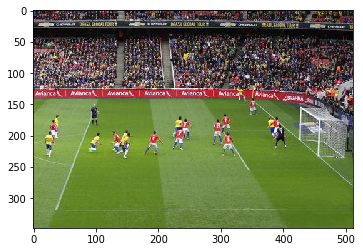

In [28]:
image_file = validation_images_path.ls()[1720]
image = skimage.io.imread(image_file)
image_id = image_file.name[:-4]

plt.imshow(image)

valid_labels.loc[valid_labels.ImageID == image_id]

In [30]:
valid_boxes = pd.read_csv(data_path/'boxes'/'validation.csv')
valid_boxes['Label as string'] = valid_boxes.apply(lambda row: code_to_class[row.LabelName], axis=1)
valid_boxes.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf,Label as string
0,0001eeaf4aed83f9,/m/0cmf2,0.022673,0.964200,0.071038,0.800546,0,Airplane
1,000595fe6fee6369,/m/02xwb,0.141384,0.179676,0.676275,0.731707,0,Fruit
2,000595fe6fee6369,/m/02xwb,0.213549,0.253314,0.299335,0.354767,0,Fruit
3,000595fe6fee6369,/m/02xwb,0.232695,0.288660,0.490022,0.545455,0,Fruit
4,000595fe6fee6369,/m/02xwb,0.245950,0.291605,0.547672,0.605322,0,Fruit


,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf,Label as string
111240,7ede75bce7b52da1,/m/01g317,0.000000,0.998512,0.000000,0.679825,1,Person
111241,7ede75bce7b52da1,/m/01226z,0.688988,0.696429,0.320175,0.328947,0,Football


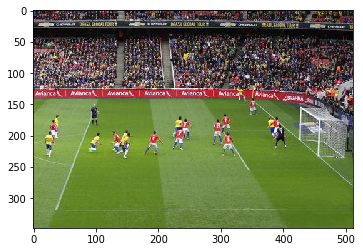

In [35]:
image_file = validation_images_path.ls()[1720]
image = skimage.io.imread(image_file)
image_id = image_file.name[:-4]

plt.imshow(image)

valid_boxes.loc[valid_boxes.ImageID == image_id]

In [86]:
def show_image_with_boxes(image_file):
    image = skimage.io.imread(image_file)
    image_id = image_file.name[:-4]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image)
    
    if 'validation' in str(image_file):
        boxes_df = valid_boxes.loc[valid_boxes.ImageID == image_id]
    else:
        boxes_df = train_boxes.loc[train_boxes.ImageID == image_id]
    
    height, width, _ = image.shape
    
    for index, row in boxes_df.iterrows():
        box = mpatches.Rectangle((row.XMin * width, row.YMin * height),
                                 (row.XMax - row.XMin) * width,
                                 (row.YMax - row.YMin) * height,
                                 fill=False, edgecolor='red', 
                                 linewidth=2)
        ax.add_patch(box)
        
        ax.text(
            row.XMin * width,
            (row.YMin * height) - 4,
            row['Label as string'],
            fontsize=16
        )
        
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

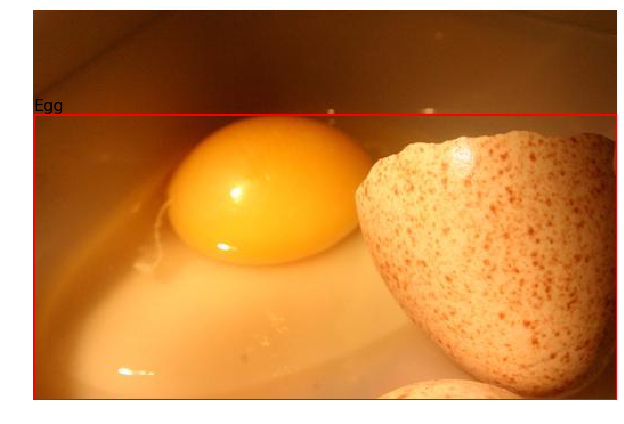

In [91]:
show_image_with_boxes(validation_images_path.ls()[1627])